# Flocks, Herds, and Traffic Jams

Code examples from [Think Complexity, 2nd edition](https://thinkcomplex.com).

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from utils import decorate, savefig

Here's the `Driver` class from Chapter 10.

In [12]:
class Driver:
    
    def __init__(self, loc, speed=4):
        """Initialize the attributes.
        
        loc: position on track, in miles
        speed: speed in miles per hour
        """
        self.start = loc
        self.loc = loc
        self.speed = speed
        
    def choose_acceleration(self, dist):
        """Chooses acceleration based on distance.
        
        dist: distance from the car in front
        
        returns: acceleration
        """
        return 1
        
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start

And the Highway.

In [16]:
from Cell2D import Cell2D

class Highway(Cell2D):
    
    max_acc = 1
    min_acc = -10
    speed_limit = 40
    
    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        """Initializes the attributes.
        
        n: number of drivers
        length: length of the track
        eps: variability in speed
        constructor: function used to instantiate drivers
        """
        self.length = length
        self.eps = eps
        self.crashes = 0

        # create the drivers
        locs = np.linspace(0, length, n, endpoint=False)
        self.drivers = [constructor(loc) for loc in locs]
        
        # and link them up
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        """Performs one time step."""
        for driver in self.drivers:
            self.move(driver)
            
    def move(self, driver):
        """Updates `driver`.
        
        driver: Driver object
        """
        # get the distance to the next driver
        dist = self.distance(driver)

        # let the driver choose acceleration
        acc = driver.choose_acceleration(dist)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc
            
        # add random noise to speed
        speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # keep it nonnegative and under the speed limit
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)
        
        # if current speed would collide with next driver, stop
        if speed > dist:
            speed = 0
            self.crashes += 1
            
        # update speed and loc
        driver.speed = speed
        driver.loc += speed
            
    def distance(self, driver):
        """Distance from `driver` to next driver.
        
        driver: Driver object
        """
        dist = driver.next.loc - driver.loc
        # fix wraparound
        if dist < 0:
            dist += self.length
        return dist
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])
    
    def draw(self):
        """Draws the drivers and shows collisions.
        """
        drivers = self.drivers
        xs, ys = self.get_coords(drivers)
        plt.plot(xs, ys, 'bs', markersize=10, alpha=0.7)
        
        stopped = [driver for driver in self.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped, r=0.8)
        plt.plot(xs, ys, 'r^', markersize=12, alpha=0.7)
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def get_coords(self, drivers, r=1):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        drivers: sequence of Driver
        r: radius of the circle
        
        returns: tuple of sequences, (xs, ys)
        """
        locs = np.array([driver.loc for driver in drivers])
        locs *= 2 * np.pi / self.length
        xs = r * np.cos(locs)
        ys = r * np.sin(locs)
        return xs, ys

Make the animation:

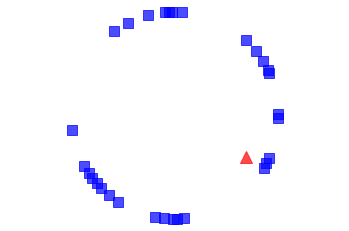

In [17]:
highway = Highway(30, eps=0.02)
highway.animate(frames=50, interval=0.2)

And generate the figure:

Saving figure to file figs/chap10-1


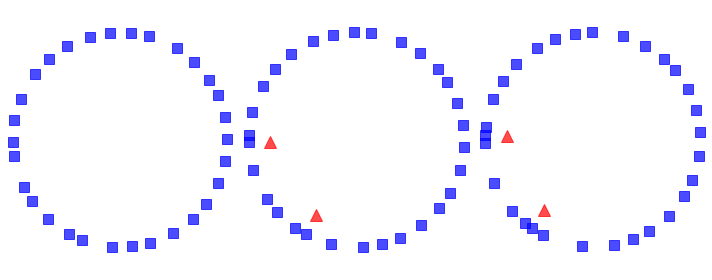

In [15]:
from utils import three_frame

highway = Highway(30, eps=0.02)
three_frame(highway, [16, 1, 1], seed=22)
savefig('figs/chap10-1')

Explore the relationship between `eps` and average speed.

In [90]:
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

Generate the figure:

Saving figure to file figs/chap10-2


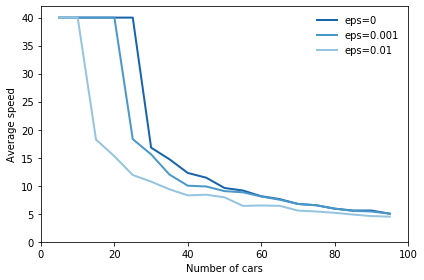

In [91]:
np.random.seed(20)
from utils import set_palette
set_palette('Blues', 4, reverse=True)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    plt.plot(xs, ys, label='eps=%g' % eps)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

savefig('figs/chap10-2')

**Exercise:** In the traffic jam simulation, define a class, `BetterDriver`,
that inherits from `Driver` and overrides `choose_acceleration`.
See if you can define driving rules that do better than the basic
implementation in `Driver`.  You might try to achieve higher
average speed, or a lower number of collisions.

In [153]:
# Here's a first attempt

# Accelerate based on distance
class BetterDriver(Driver):
    def choose_acceleration(self, d):
        threshold = 22
        factor = .005
        if d > threshold:
            return 1
        acc = factor*(d-threshold)
        return acc
    
# DO not accelerate if too close 
class BetterDriver(Driver):
    def choose_acceleration(self, d):
        return d> 20

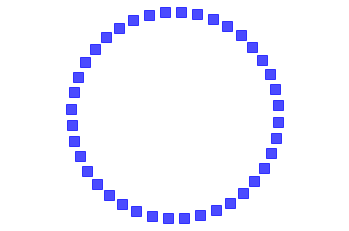

In [154]:
highway = Highway(40, eps=0.0, constructor=BetterDriver)
highway.animate(100)

In [155]:
# for threshold in range(30,200, 5):
#     for factor in [.0001, .001, .01, .1]:
#         xs, ys = run_simulation(eps=0.0, constructor=BetterDriver)
#         print(threshold, factor ,sum(ys))
   
    


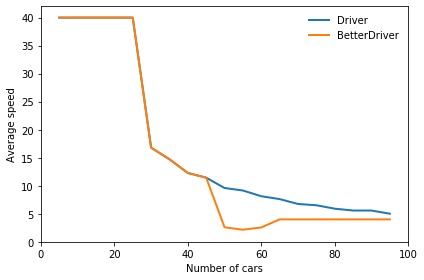

In [156]:
for constructor in [Driver, BetterDriver]:
    xs, ys = run_simulation(eps=0.0, constructor=constructor)
    plt.plot(xs, ys, label=constructor.__name__)
    
decorate(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])